# Predicción de la eficiencia del combustible

Predicción de MPG con una MLP usando TensorFlow/Keras, NumPy, Pandas y el dataset Auto MPG (UCI vía ucimlrepo). Objetivo: practicar regresión supervisada de punta a punta.

### Conjunto de datos
Apunte: Auto MPG (UCI) — regresión para predecir `mpg` (millas/galón) de autos 70s–80s. Sirve para practicar pipeline básico de ML.

In [1]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets


Vista rápida de `X` (features)

In [2]:
X.head()


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


Características en `X` (features):
- cylinders
- displacement (in³)
- horsepower
- weight (lb)
- acceleration (0–60s)
- model year
- origin (1=EEUU, 2=Europa, 3=Japón)

Estas son las variables de entrada.

Vista rápida de `y` (target)

In [3]:
y.head()


,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


Target `mpg`: eficiencia de combustible (millas/galón).

### Preprocesamiento de datos
Apuntes:
- Inspección de nulos en `X` y `y` para decidir limpieza.

In [4]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   horsepower    392 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    int64  
 6   origin        398 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 21.9 KB


In [5]:
y.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Limpieza rápida: concateno `X`+`y` y uso `dropna()` para quitar filas con nulos en cualquier columna.

In [6]:
import pandas as pd

df = pd.concat([X, y], axis=1).dropna()


Resumen y chequeo general: `describe()` para escalas/outliers y `info()` para tipos.

In [7]:
df.describe()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,194.411990,5.471939,104.469388,2977.584184,15.541327,75.979592,1.576531,23.445918
std,104.644004,1.705783,38.491160,849.402560,2.758864,3.683737,0.805518,7.805007
min,68.000000,3.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,105.000000,4.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,17.000000
50%,151.000000,4.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,22.750000
75%,275.750000,8.000000,126.000000,3614.750000,17.025000,79.000000,2.000000,29.000000
max,455.000000,8.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   horsepower    392 non-null    float64
 3   weight        392 non-null    int64  
 4   acceleration  392 non-null    float64
 5   model_year    392 non-null    int64  
 6   origin        392 non-null    int64  
 7   mpg           392 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 27.6 KB


Re-defino `X` y `y` tras la limpieza

In [9]:
X = df.drop('mpg', axis=1)
y = df['mpg']


Split: entrenamiento (80%) y prueba (20%) para evaluar generalización

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=1
)


Shapes train/test (chequeo rápido de la partición):

In [11]:
print(X_train.shape)
print(X_test.shape)


(313, 7)
(79, 7)


Escalado: `StandardScaler` (media 0, std 1) para estabilizar entrenamiento

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Alternativa: `MinMaxScaler` (escala a [0,1]) si las features tienen rangos muy distintos.

## Red neuronal multicapa
Modelo MLP: capas `Dense` con activación ReLU; salida lineal (1 neurona) para regresión.

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Definir el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])


/home/nictez/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-03 21:03:24.463591: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Nota: Arquitectura sencilla con `Sequential` + capas `Dense` (ReLU). Salida lineal (1 neurona) para regresión.

**Compilar el modelo**

Optimizador: Adam (lr=0.001).

In [14]:
from tensorflow.keras.optimizers import Adam

# Tasa de aprendizaje deseada
learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)


In [15]:
model.compile(
    optimizer=adam_optimizer,
    loss='mean_squared_error',
    metrics=['root_mean_squared_error'],
)


Pérdida: `mean_squared_error` (MSE). Métrica monitor: `root_mean_squared_error` (RMSE).

**Entrenamiento**

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=20, batch_size=1,
    validation_data=(X_test, y_test)
)


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 190.3668 - root_mean_squared_error: 13.7973 - val_loss: 20.2571 - val_root_mean_squared_error: 4.5008
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.4879 - root_mean_squared_error: 3.5338 - val_loss: 17.0428 - val_root_mean_squared_error: 4.1283
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6149 - root_mean_squared_error: 3.1008 - val_loss: 10.5125 - val_root_mean_squared_error: 3.2423
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4472 - root_mean_squared_error: 3.0736 - val_loss: 12.7012 - val_root_mean_squared_error: 3.5639
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7701 - root_mean_squared_error: 2.9614 - val_loss: 13.6237 - val_root_mean_squared_error: 3.6910
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3368 - root_mean_squared_error: 2.8874 - val_loss: 10.5384 - val_root_mean_squared_error: 3.2463
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s

Entreno con `fit`: defino épocas, `batch_size` y validación con `X_test/y_test` para monitorear overfitting.

### Gráfica de pérdida (train vs. val)

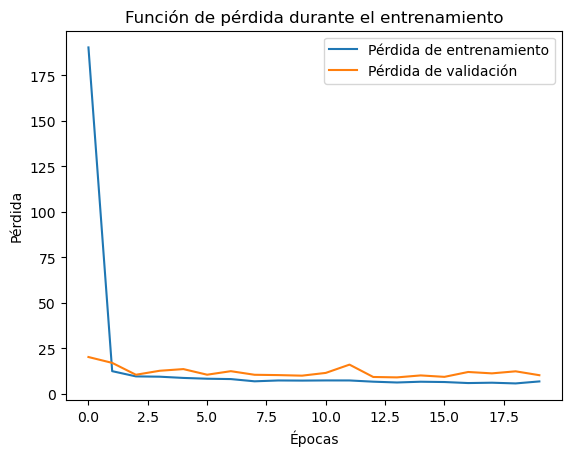

In [17]:
import matplotlib.pyplot as plt

# Graficar la función de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Función de pérdida durante el entrenamiento')
plt.show()


Esperado: la pérdida de entrenamiento y validación deberían bajar; si divergen mucho, hay overfitting/underfitting.

## Evaluación
Nota: evalúo en test para estimar desempeño fuera de entrenamiento (generalización).

In [18]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Mean Absolute Error: {test_mae:.2f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 10.2657 - root_mean_squared_error: 3.2040
Test Mean Absolute Error: 3.20


## Predicciones
Nota: genero `predictions` sobre `X_test` y comparo con valores reales para una inspección rápida.

In [19]:
predictions = model.predict(X_test)
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(comparison.head())


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
     Actual  Predicted
82     23.0  20.519709
167    29.0  26.501465
356    32.4  33.057247
120    19.0  18.560818
385    38.0  36.950039


## Otras métricas
Notas:
- R² cercano a 1 = buen ajuste; negativo = peor que línea base.
- MSE más bajo = mejor; RMSE es la raíz del MSE (misma unidad que `mpg`).

In [20]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, predictions)
print(f'R²: {r2}')

mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')


R²: 0.851913605482556
MSE: 10.265685805427525
